# Objective
# Pinpoint errors, decrease risk and find fraud immediately rather than over months/years
# Empower accountants and auditors to work on high risk cases vs mundane tasks

# Outcome
# Detected abnormal journal entries in accounting systems
# Models that outperformed auditors, ranking in top 10%
# Document analysis to verify evidence auditors receive, spending less time on reading and comparing documents

# Business Value
# Automate manual audit work, improving OPEX and focusing auditor time on complex tasks and cases

# To do the document verification process in an audit, we can create a simplified workflow where we "verify" the documents associated with each journal entry. This can be done by generating outcomes for document verification (e.g., whether the document is complete, matches the transaction, and is valid).


# Plan:
# Load the dataset.
# Create a verification process by adding columns like:
# Document_Exists: Whether the document exists.
# Document_Matches_Entry: Whether the document matches the journal entry.
# Document_Valid: Whether the document is valid based on internal criteria.


# Descriptive analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the dataset

data = pd.read_csv('Audit_verification.csv')

# Display initial data
data.head()



,TransactionID,AccountBalance,Amount,Is_Manual_Entry,Timestamp,Document_Exists,Document_Matches_Entry,Document_Valid,Verification_Failure
0,1,16795,16757,0,2024-10-17 12:10:21.701953,1,1,1,0
1,2,1860,110,0,2024-10-17 12:11:21.701953,0,0,0,1
2,3,77820,18774,1,2024-10-17 12:12:21.701953,1,1,1,0
3,4,55886,8190,0,2024-10-17 12:13:21.701953,1,1,1,0
4,5,7265,7248,0,2024-10-17 12:14:21.701953,1,1,1,0


In [2]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   TransactionID           100000 non-null  int64 
 1   AccountBalance          100000 non-null  int64 
 2   Amount                  100000 non-null  int64 
 3   Is_Manual_Entry         100000 non-null  int64 
 4   Timestamp               100000 non-null  object
 5   Document_Exists         100000 non-null  int64 
 6   Document_Matches_Entry  100000 non-null  int64 
 7   Document_Valid          100000 non-null  int64 
 8   Verification_Failure    100000 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 6.9+ MB
None


# PREPROCESSING

In [3]:

# Convert 'Timestamp' to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Feature Engineering

# 1. Extract time-based features
data['Hour'] = data['Timestamp'].dt.hour
data['Day_of_Week'] = data['Timestamp'].dt.dayofweek
data['Month'] = data['Timestamp'].dt.month
data['Day_of_Month'] = data['Timestamp'].dt.day



In [5]:
data.head()

,TransactionID,AccountBalance,Amount,Is_Manual_Entry,Timestamp,Document_Exists,Document_Matches_Entry,Document_Valid,Verification_Failure,Hour,Day_of_Week,Month,Day_of_Month
0,1,16795,16757,0,2024-10-17 12:10:21.701953,1,1,1,0,12,3,10,17
1,2,1860,110,0,2024-10-17 12:11:21.701953,0,0,0,1,12,3,10,17
2,3,77820,18774,1,2024-10-17 12:12:21.701953,1,1,1,0,12,3,10,17
3,4,55886,8190,0,2024-10-17 12:13:21.701953,1,1,1,0,12,3,10,17
4,5,7265,7248,0,2024-10-17 12:14:21.701953,1,1,1,0,12,3,10,17


In [5]:
# 2. Cyclical encoding for Hour and Day_of_Week
data['Hour_sin'] = np.sin(2 * np.pi * data['Hour']/24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour']/24)
data['Day_of_Week_sin'] = np.sin(2 * np.pi * data['Day_of_Week']/7)
data['Day_of_Week_cos'] = np.cos(2 * np.pi * data['Day_of_Week']/7)


In [6]:
data.head()

,TransactionID,AccountBalance,Amount,Is_Manual_Entry,Timestamp,Document_Exists,Document_Matches_Entry,Document_Valid,Verification_Failure,Hour,Day_of_Week,Month,Day_of_Month,Hour_sin,Hour_cos,Day_of_Week_sin,Day_of_Week_cos
0,1,16795,16757,0,2024-10-17 12:10:21.701953,1,1,1,0,12,3,10,17,1.224647e-16,-1.0,0.433884,-0.900969
1,2,1860,110,0,2024-10-17 12:11:21.701953,0,0,0,1,12,3,10,17,1.224647e-16,-1.0,0.433884,-0.900969
2,3,77820,18774,1,2024-10-17 12:12:21.701953,1,1,1,0,12,3,10,17,1.224647e-16,-1.0,0.433884,-0.900969
3,4,55886,8190,0,2024-10-17 12:13:21.701953,1,1,1,0,12,3,10,17,1.224647e-16,-1.0,0.433884,-0.900969
4,5,7265,7248,0,2024-10-17 12:14:21.701953,1,1,1,0,12,3,10,17,1.224647e-16,-1.0,0.433884,-0.900969


In [10]:
# Drop unnecessary columns
features_to_drop = ['Timestamp', 'Verification_Failure']
data_clean = data.drop(columns=features_to_drop)
# Fill any remaining NaN values (from rolling std)
data_clean.fillna(0, inplace=True)

# Display the engineered features
print("\nData after Feature Engineering:")
data_clean.head()



Data after Feature Engineering:


,TransactionID,AccountBalance,Amount,Is_Manual_Entry,Document_Exists,Document_Matches_Entry,Document_Valid,Hour,Day_of_Week,Month,Day_of_Month,Hour_sin,Hour_cos,Day_of_Week_sin,Day_of_Week_cos
0,1,16795,16757,0,1,1,1,12,3,10,17,1.224647e-16,-1.0,0.433884,-0.900969
1,2,1860,110,0,0,0,0,12,3,10,17,1.224647e-16,-1.0,0.433884,-0.900969
2,3,77820,18774,1,1,1,1,12,3,10,17,1.224647e-16,-1.0,0.433884,-0.900969
3,4,55886,8190,0,1,1,1,12,3,10,17,1.224647e-16,-1.0,0.433884,-0.900969
4,5,7265,7248,0,1,1,1,12,3,10,17,1.224647e-16,-1.0,0.433884,-0.900969


In [11]:
# Select features for the model
feature_columns = ['TransactionID',
    'AccountBalance', 'Amount', 'Is_Manual_Entry', 'Hour', 'Day_of_Week', 'Month',
    'Day_of_Month', 'Hour_sin', 'Hour_cos', 'Day_of_Week_sin', 'Day_of_Week_cos','Document_Exists', 'Document_Matches_Entry', 'Document_Valid']
X = data_clean[feature_columns]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Isolation Forest model

In [13]:


# Initialize and train the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X_scaled)

# Predict anomalies
data_clean['Anomaly_Score'] = model.decision_function(X_scaled)
data_clean['Is_Anomaly'] = model.predict(X_scaled)
data_clean['Is_Anomaly'] = data_clean['Is_Anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Display anomalies
anomalies = data_clean[data_clean['Is_Anomaly'] == 1]
print(f"\nTotal anomalies detected: {len(anomalies)}")
print(anomalies.head())

# Save the results
output_file = 'Downloads/isolation_forest_anomalies.csv'
data_clean.to_csv(output_file, index=False)
print(f"\nAnomaly detection results saved to '{output_file}'.")




Total anomalies detected: 5000
     TransactionID  AccountBalance  Amount  Is_Manual_Entry  Document_Exists  \
1                2            1860     110                0                0   
11              12           42090    5696                1                0   
27              28           85478    4241                1                1   
33              34           36773   15754                1                0   
121            122           90135    6560                1                0   

     Document_Matches_Entry  Document_Valid  Hour  Day_of_Week  Month  \
1                         0               0    12            3     10   
11                        0               0    12            3     10   
27                        0               0    12            3     10   
33                        0               0    12            3     10   
121                       0               0    14            3     10   

     Day_of_Month      Hour_sin  Hour_cos  Day_o

# Evaluation model

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assume 'True_Anomaly' column exists in the dataset for ground truth
# Compare the predicted anomalies with the true anomalies
true_labels = data['Verification_Failure']  # This column should be in the dataset
predicted_labels = data_clean['Is_Anomaly']

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.6594
Precision: 0.9838
Recall: 0.1265
F1-Score: 0.2241


# Visualization

C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


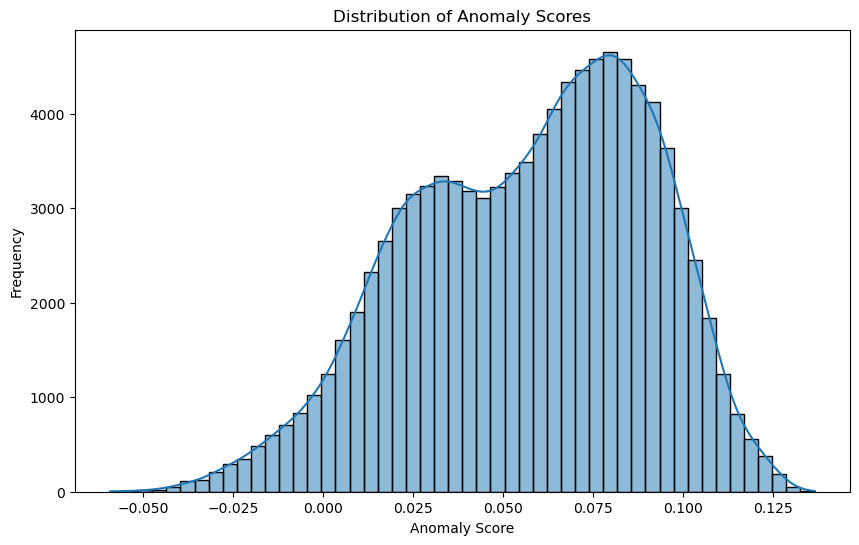

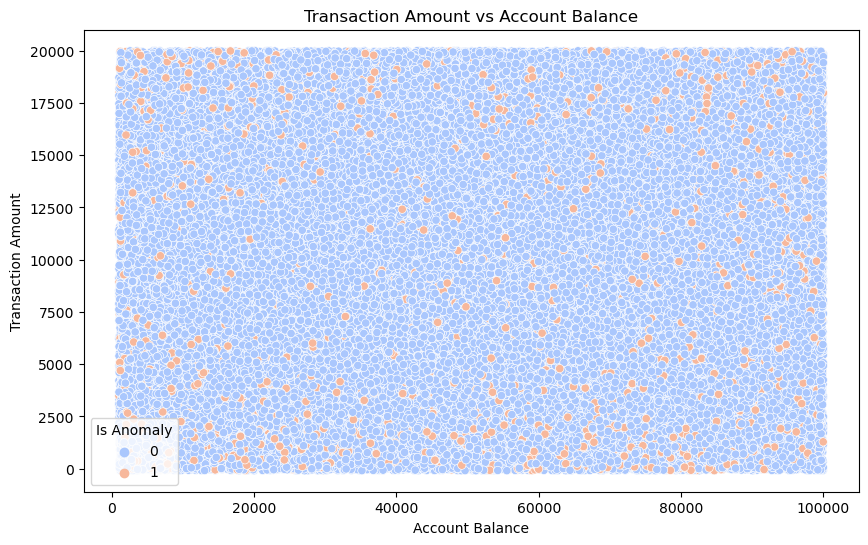

C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


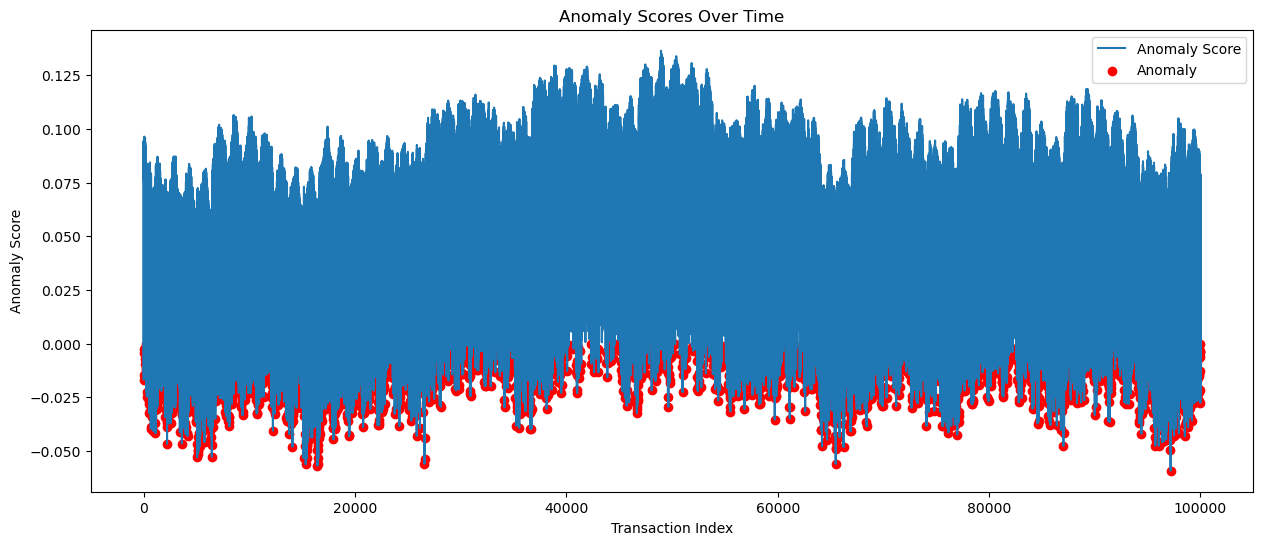

In [15]:


# 1. Distribution of Anomaly Scores
plt.figure(figsize=(10,6))
sns.histplot(data_clean['Anomaly_Score'], bins=50, kde=True)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

# 2. Scatter plot of Amount vs AccountBalance colored by Anomaly
plt.figure(figsize=(10,6))
sns.scatterplot(x='AccountBalance', y='Amount', hue='Is_Anomaly', data=data_clean, palette='coolwarm')
plt.title('Transaction Amount vs Account Balance')
plt.xlabel('Account Balance')
plt.ylabel('Transaction Amount')
plt.legend(title='Is Anomaly')
plt.show()

# 3. Time Series of Anomalies
plt.figure(figsize=(15,6))
sns.lineplot(x=data_clean.index, y='Anomaly_Score', data=data_clean, label='Anomaly Score')
plt.scatter(anomalies.index, anomalies['Anomaly_Score'], color='red', label='Anomaly')
plt.title('Anomaly Scores Over Time')
plt.xlabel('Transaction Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()
